# XSVS pipeline

"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [1]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [2]:
#hdr = db[{{ uid }}]

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time

## Lazy Eiger Handler (later will goto databroker)


In [4]:
import h5py
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages

EIGER_MD_DICT = {
    'y_pixel_size': 'entry/instrument/detector/y_pixel_size',
    'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
    'detector_distance': 'entry/instrument/detector/detector_distance',
    'incident_wavelength': 'entry/instrument/beam/incident_wavelength',
    'frame_time': 'entry/instrument/detector/frame_time',
    'beam_center_x': 'entry/instrument/detector/beam_center_x',
    'beam_center_y': 'entry/instrument/detector/beam_center_y',
    'count_time': 'entry/instrument/detector/count_time',
    'binary_mask': 'entry/instrument/detector/detectorSpecific/pixel_mask',
}

class FixedEigerImages(EigerImages):
    def __init__(self, path, metadata):
        super().__init__(path)
        self._metadata = metadata
    
    @property
    def md(self):
        return self._metadata
    
    @property
    def dtype(self):
        return self.pixel_type
    
    @property
    def shape(self):
        return self.frame_shape

class LazyEigerHandler(HandlerBase):
    specs = {'AD_EIGER'} | HandlerBase.specs
    def __init__(self, fpath, frame_per_point, mapping=None):
        # create pims handler
        self.vals_dict = EIGER_MD_DICT.copy()
        if mapping is not None:
            self.vals_dict.update(mapping)
        self._base_path = fpath
        self.fpp = frame_per_point

    def __call__(self, seq_id):
        import h5py
        master_path = '{}_{}_master.h5'.format(self._base_path, seq_id)
        md = {}
        print('hdf5 path = %s' % master_path)
        with h5py.File(master_path, 'r') as f:
            #md = {k: f[v].value for k, v in self.vals_dict.items()}
            md = {k: f[v][()] for k, v in self.vals_dict.items()}
        # the pixel mask from the eiger contains:
        # 1  -- gap
        # 2  -- dead
        # 4  -- under-responsive
        # 8  -- over-responsive
        # 16 -- noisy
        binary_mask = md['binary_mask']
        binary_mask[binary_mask>0] = 1
        binary_mask[binary_mask==0] = 2
        binary_mask[binary_mask==1] = 0
        binary_mask[binary_mask==2] = 1
        md['framerate'] = 1./md['frame_time']
        # TODO Return a multi-dimensional PIMS seq
        return FixedEigerImages(master_path, md)

deregister_handler('AD_EIGER')
_HANDLER_CACHE.clear()
register_handler('AD_EIGER', LazyEigerHandler)

In [5]:
#%matplotlib notebook
%matplotlib inline

## Get the events from uid

In [6]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("%s: %s" % (key, val))

In [7]:
uid = '8a3f3e04'
hdr = db[uid]

In [8]:
ev, = get_events(hdr, ['eiger_4M_cam_img_image_lightfield'], fill = True)

hdf5 path = /XF11ID/data/2015/10/30/ad0ec08c-201e-4723-a8a6_9093_master.h5


In [9]:
from datetime import datetime
dt = datetime.fromtimestamp(hdr['start'].time)
path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
path

'/XF11ID/analysis/2015/10/30/'

In [10]:
imgs = ev['data']['eiger_4M_cam_img_image_lightfield']
print (imgs)
Nimg=len(imgs)

<Frames>
Length: 2500 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16


In [11]:
imgs.md

{'beam_center_x': 840.0,
 'beam_center_y': 336.0,
 'binary_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'count_time': 0.0049999999,
 'detector_distance': 4.8400002,
 'frame_time': 0.00501,
 'framerate': 199.60079982206346,
 'incident_wavelength': 1.3794414,
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

## Note:  Obtain the following experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [12]:
# The physical size of the pixels
dpix = 0.075  
 
lambda_ = 1.5498    # wavelegth of the X-rays in Angstroms
Ldet = 5000.        # detector to sample distance

exposuretime= 100 * 10**(-3) 
acquisition_period = 100 * 10**(-3)  

#deadtime= 0   # 60e-6 
#timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  


## load a mask if exist

otherwise create a mask using Mask pipeline

In [13]:
#mask = np.load(uid+"_mask.npy")
mask = np.load( path +  str(uid)+"_mask.npy")
mask = np.int_( mask )  #convert mask to integer data type

## Plot the mask¶

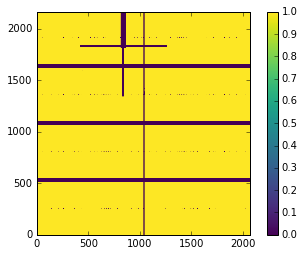

In [14]:
fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0,vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Interactive way to browse through images.
Note : Provide the number of images that you want to browse

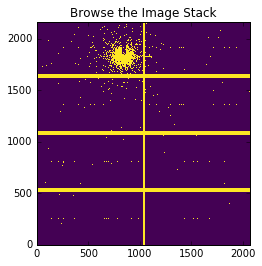

<function __main__.view_image>

In [15]:
from ipywidgets import interact
%matplotlib inline
def view_image(i):
    plt.imshow(imgs[i], interpolation='nearest', cmap='viridis',
               vmin=0, vmax=1e0, origin="lower")
    plt.title("Browse the Image Stack")
    plt.show()
    
interact(view_image, i=(0, 2499))

## Movie

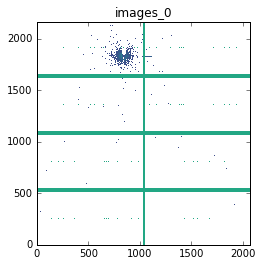

In [16]:
def view_image(sleeps=1, ims=0, ime = 1):    
    fig, ax = plt.subplots()  
    for i in range( ims, ime  ):
        ax.imshow(imgs[i],  interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm( vmin=0.001, vmax=1e10 ) )
        ax.set_title("images_%s"%i)
        time.sleep( sleeps )
        plt.draw()
        
view_image(.2, 0, 1)

### hey, let's see if any images are bad!

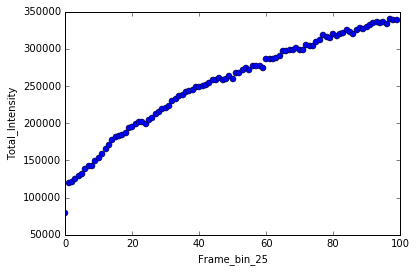

In [17]:
bin_img = 25
imgsum = [np.sum(img *mask) for img in imgs[::bin_img ]]

fig, ax = plt.subplots()  
ax.plot(imgsum,'bo')
ax.set_xlabel( 'Frame_bin_%s'%bin_img )
ax.set_ylabel( 'Total_Intensity' )
plt.show()

## Get the Averaged Image Data

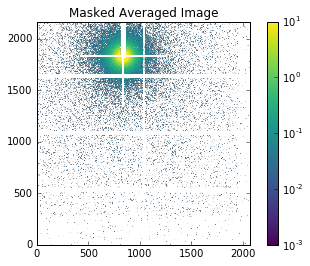

In [18]:
avg_img = np.average(imgs[::50], axis=0)*mask

img_mask = avg_img * mask

fig, ax = plt.subplots()
im = ax.imshow(img_mask, cmap='viridis',origin='lower',
               norm= LogNorm(vmin=0.001, vmax=1e1))
ax.set_title("Masked Averaged Image")
fig.colorbar(im)
plt.show()

In [19]:
avg_img.shape

(2167, 2070)

## Import all the required packages for  Data Analysis

* scikit-xray - data analysis tools for X-ray science 
    - https://github.com/scikit-xray/scikit-xray
* xray-vision - plotting helper functions for X-ray science
    - https://github.com/Nikea/xray-vision

In [20]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mask.manual_mask import ManualMask

import skxray.core.roi as roi
import skxray.core.speckle as speckle
import skxray.core.utils as utils

## Get the approximate center and see the statistic to make sure

In [21]:
imgs.md['beam_center_x'], imgs.md['beam_center_y']

(840.0, 336.0)

In [22]:
#center = (imgs.md['beam_center_x'], imgs.md['beam_center_y'])
center = [840, 1830]  # center of the speckle pattern
center=[center[1], center[0]]

#center = [834, 340]
center = [ 2167 - 340,834]
center

[1827, 834]

In [23]:
#img_mask = img_mask[::-1,:]

### Circular Average : compute the radial integartion from the center of the speckle pattern

In [24]:
bin_centers, ring_averages= roi.circular_average(img_mask, 
        center, threshold=0, nx=2000, pixel_size=(dpix, dpix))

#  convert to q (reciprocal space)
two_theta = utils.radius_to_twotheta(Ldet, bin_centers)
q_val = utils.twotheta_to_q(two_theta, lambda_)

In [25]:
dpix

0.075

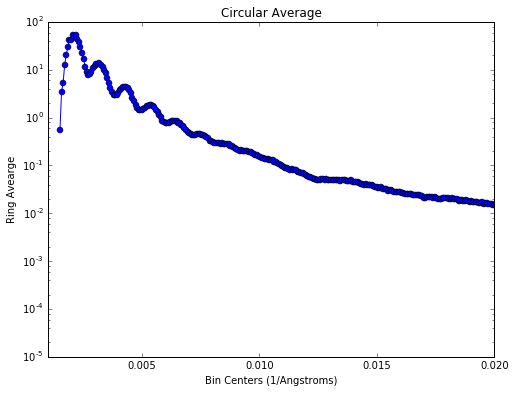

In [26]:
fig,axes = plt.subplots(figsize=(8, 6))
axes.semilogy(q_val, ring_averages, '-o')

#axes.plot(q_val, ring_averages, '-o')
axes.set_title("Circular Average")
axes.set_ylabel("Ring Avearge")
axes.set_xlabel("Bin Centers (1/Angstroms)")
axes.set_xlim(0.001, 0.02)

plt.show()

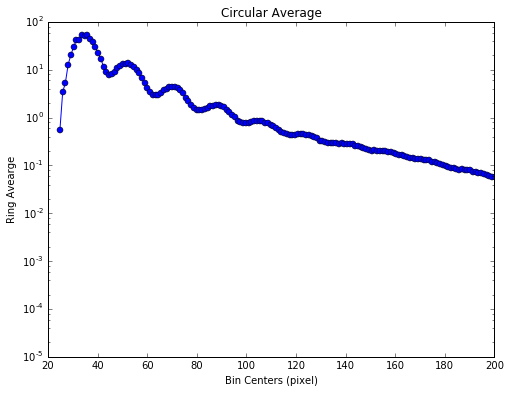

In [27]:
fig,axes = plt.subplots(figsize=(8, 6))
axes.semilogy(bin_centers/dpix, ring_averages, '-o')

#axes.plot(q_val, ring_averages, '-o')
axes.set_title("Circular Average")
axes.set_ylabel("Ring Avearge")
axes.set_xlabel("Bin Centers (pixel)")
axes.set_xlim(20, 200)

plt.show()

## Create label array (Q rings)


### Circular Average : compute the radial integartion from the center of the speckle pattern

In [28]:
inner_radius = 40 # radius of the first ring
width = 2       # width of each ring
spacing =  (149 - 44)/9 - 2    # spacing between rings
num_rings = 6   # number of rings

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[  40.        ,   42.        ],
       [  51.66666667,   53.66666667],
       [  63.33333333,   65.33333333],
       [  75.        ,   77.        ],
       [  86.66666667,   88.66666667],
       [  98.33333333,  100.33333333]])

In [29]:
two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_ring_val = utils.twotheta_to_q(two_theta, lambda_)

q_ring_center = np.average(q_ring_val, axis=1)
q_ring_center

array([ 0.00249333,  0.00320281,  0.00391229,  0.00462178,  0.00533126,
        0.00604074])

In [30]:
rings = roi.rings(edges, center, avg_img.shape)

ring_mask = rings*mask

## Extract the labeled array

In [31]:
labels, indices = roi.extract_label_indices(ring_mask)
labels

array([6, 6, 6, ..., 6, 6, 6])

In [32]:
indices

array([3577778, 3577779, 3577780, ..., 3981415, 3981416, 3981417])

## Number of pixels in each q ring

In [33]:
nopr = np.bincount( np.array(labels, dtype=int) )[1:]
nopr

array([ 281,  419,  591,  739,  903, 1040])

#### Plot the labled array

In [34]:
def show_label_array_on_image0(ax, image, label_array, cmap=None,
                              imshow_cmap='gray', norm=LogNorm(), **kwargs):
    """
    This will plot the required ROI's(labeled array) on the image
    Additional kwargs are passed through to `ax.imshow`.
    If `vmin` is in kwargs, it is clipped to minimum of 0.5.
    Parameters
    ----------
    ax : Axes
        The `Axes` object to add the artist too
    image : array
        The image array
    label_array : array
        Expected to be an unsigned integer array.  0 is background,
        positive integers label region of interest
    cmap : str or colormap, optional
        Color map to use for plotting the label_array, defaults to 'None'
    imshow_cmap : str or colormap, optional
        Color map to use for plotting the image, defaults to 'gray'
    norm : str, optional
        Normalize scale data, defaults to 'Lognorm()'
    Returns
    -------
    im : AxesImage
        The artist added to the axes
    im_label : AxesImage
        The artist added to the axes
    """
    ax.set_aspect('equal')
    im = ax.imshow(image, cmap=imshow_cmap, interpolation='none', norm=norm,
                   **kwargs)
    im_label = mpl_plot.show_label_array(ax, label_array, cmap=cmap, norm=norm,
                                **kwargs)
    return im, im_label

In [35]:
def show_label_array_on_image(ax, image, label_array, cmap=None,norm=None,
                              imshow_cmap='gray', **kwargs):  #norm=LogNorm(), 
    """
    This will plot the required ROI's(labeled array) on the image
    Additional kwargs are passed through to `ax.imshow`.
    If `vmin` is in kwargs, it is clipped to minimum of 0.5.
    Parameters
    ----------
    ax : Axes
        The `Axes` object to add the artist too
    image : array
        The image array
    label_array : array
        Expected to be an unsigned integer array.  0 is background,
        positive integers label region of interest
    cmap : str or colormap, optional
        Color map to use for plotting the label_array, defaults to 'None'
    imshow_cmap : str or colormap, optional
        Color map to use for plotting the image, defaults to 'gray'
    norm : str, optional
        Normalize scale data, defaults to 'Lognorm()'
    Returns
    -------
    im : AxesImage
        The artist added to the axes
    im_label : AxesImage
        The artist added to the axes
    """
    ax.set_aspect('equal')
    im = ax.imshow(image, cmap=imshow_cmap, interpolation='none',norm=LogNorm(norm), 
                   **kwargs)  #norm=norm,
    im_label = mpl_plot.show_label_array(ax, label_array, cmap=cmap, norm=norm,
                                **kwargs)  # norm=norm,
    
    
    return im, im_label 

In [36]:
#mask

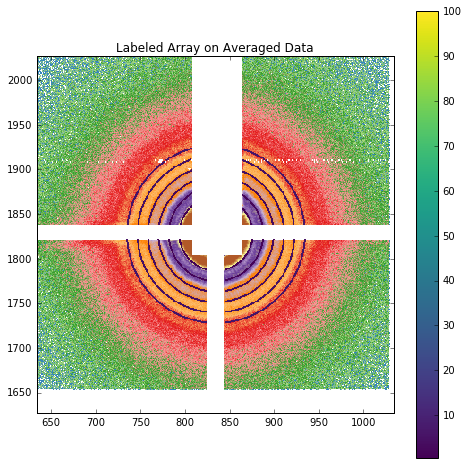

In [37]:
rings = roi.rings(edges, center, avg_img.shape)
ring_mask = rings*mask

# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array on Averaged Data")
im, im_label = show_label_array_on_image(axes, avg_img, ring_mask, cmap='viridis',
                            imshow_cmap='Paired', vmin=0.01, vmax=100. , origin="lower")
rwidth = 200 
x1,x2 = [center[1] - rwidth, center[1] + rwidth]
y1,y2 = [center[0] - rwidth, center[0] + rwidth]
axes.set_xlim( [x1,x2])
axes.set_ylim( [y1,y2])
fig.colorbar( im_label) #, vmin=0, vmax=6 )
plt.show()

# check center

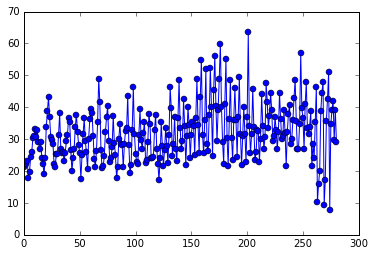

In [38]:
pixel = roi.roi_pixel_values( avg_img*mask, ring_mask, [1] )
fig,ax=plt.subplots()
ax.plot( pixel[0][0] ,'bo', ls='-' )

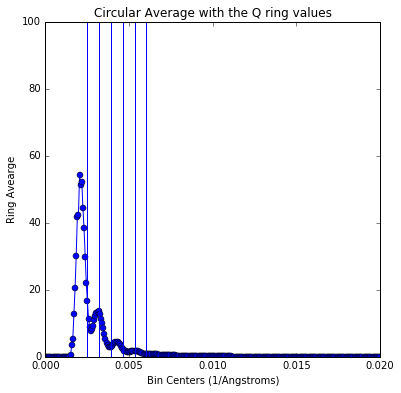

In [39]:
fig, axes = plt.subplots( figsize=(6, 6))
#axes.semilogy(q_val, ring_averages, '-o')

axes.plot(q_val, ring_averages, '-o')
axes.set_title("Circular Average with the Q ring values")
axes.set_ylabel("Ring Avearge")
axes.set_xlabel("Bin Centers (1/Angstroms)")
axes.set_xlim(0, 0.02)
axes.set_ylim(0, 100)
for i in range(num_rings):
    #axes.axvline(q_ring_val[i, 0])
    axes.axvline(q_ring_center[i])
plt.show()

##  Mask the images

In [40]:
class Masker:
    def __init__(self, indexable, mask):
        self.indexable = indexable
        self.mask = mask
    def __getitem__(self, key):
        return self.indexable[key] * self.mask
    
    
masker = Masker(imgs, mask)

##  Mean intensities for each ring

In [47]:
def mean_intensity(images, labeled_array, index=None):
    """Compute the mean intensity for each ROI in the image list

    Parameters
    ----------
    images : list
        List of images
    labeled_array : array
        labeled array; 0 is background.
        Each ROI is represented by a nonzero integer. It is not required that
        the ROI labels are contiguous
    index : int, list, optional
        The ROI's to use. If None, this function will extract averages for all
        ROIs

    Returns
    -------
    mean_intensity : array
        The mean intensity of each ROI for all `images`
        Dimensions:
            len(mean_intensity) == len(index)
            len(mean_intensity[0]) == len(images)
    index : list
        The labels for each element of the `mean_intensity` list
    """
    import scipy.ndimage.measurements as ndim
    if labeled_array.shape != images[0].shape[0:]:
        raise ValueError(
            "`images` shape (%s) needs to be equal to the labeled_array shape"
            "(%s)" % (images[0].shape, labeled_array.shape))
    # handle various input for `index`
    if index is None:
        index = list(np.unique(labeled_array))
        index.remove(0)
    try:
        len(index)
    except TypeError:
        index = [index]
    # pre-allocate an array for performance
    # might be able to use list comprehension to make this faster
    mean_intensity = np.zeros((len(images), len(index)))
    for n, img in enumerate(images):
        # use a mean that is mask-aware
        mean_intensity[n] = ndim.mean(img, labeled_array, index=index)
    return mean_intensity, index

In [42]:
def run_time(t0):
    elapsed_time = time.time() - t0
    print ('Total time: %.2f min' %(elapsed_time/60.))

In [48]:
n = 1
t0 = time.time()
mean_int_sets, index_list = mean_intensity(imgs[::n], ring_mask)
run_time(t0)


Total time: 2.63 min


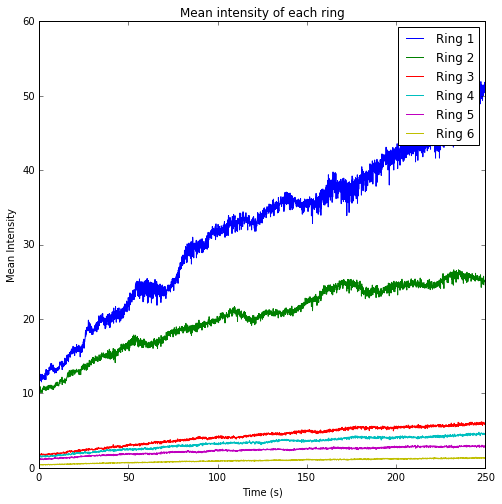

In [51]:
times = np.arange(len(imgs[::n]))*timeperframe  # get the time for each frame

%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Mean intensity of each ring")
for i in range(num_rings):
    ax.plot(times, mean_int_sets[:,i], label="Ring "+str(i+1))
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Mean Intensity")
ax.legend() 
plt.show()

In [60]:
K_mean = np.mean(mean_int_sets, axis=0)
K_mean

array([ 32.29428897,  20.23352745,   4.24605144,   3.30379269,
         2.29612359,   0.94858385])

### Find the brightest pixel in any ROI in any image in the image set.
Using roi_max_counts function from skxray.core.roi module

In [52]:
max_cts = np.max(avg_img*ring_mask)
#max_cts = 20
max_cts

63.520000000000003

In [211]:
#ring_mask

## XSVS analysis

#### Find the integration times¶
using skxray.core.utils.geometric_series

In [136]:
time_steps = utils.geometric_series(2, 500)
time_steps

[1, 2, 4, 8, 16, 32, 64, 128, 256]

In [137]:
spe_cts_all, std_dev = speckle.xsvs( (masker,), np.int_(ring_mask), timebin_num=2,
                             number_of_img=500, max_cts=int(max_cts+2))

In [138]:
speckle.xsvs??

if num_lev is None:num_lev = int(np.log( noframes/(num_buf-1))/np.log(2) +1) +1

### This will provide the normalized bin edges for each integration time

In [139]:
Knorm_bin_edges, Knorm_bin_centers = speckle.normalize_bin_edges(len(time_steps),
                                                            num_rings, K_mean, int(max_cts+2))

In [140]:
Knorm_bin_edges.shape

(9, 6)

### Plot the results for each q ring

In [141]:
num_times = spe_cts_all.shape[0]
norm_bin_edges = np.zeros((num_times, num_rings), dtype=object)
bin_edges = np.zeros_like(norm_bin_edges)
for i in range(num_times):
    for j in range(num_rings):
        bin_edges[i, j] = np.arange(int(max_cts +2 )*2**i)        
        
         

In [142]:
#np.arange(int(max_cts +2 ))

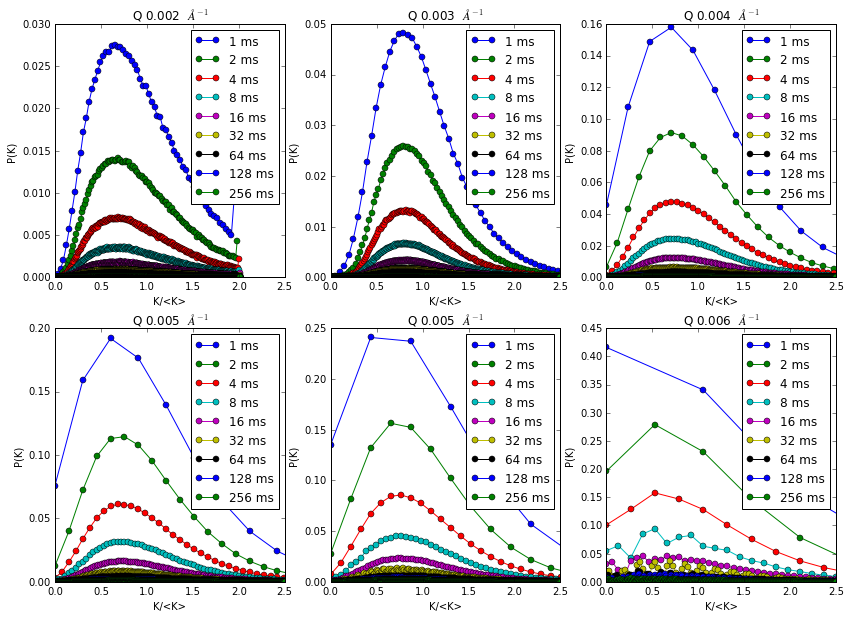

In [143]:
sx = int(round(np.sqrt(num_rings)) )
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy=int(num_rings/sx+1)
fig = plt.figure(figsize=(14, 10))
plt.title('uid= %s'%uid,fontsize=20, y =1.02)  
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    for j in range(num_times):
        axes = fig.add_subplot(sx, sy, i+1 )
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")
        art, = axes.plot(Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], '-o',
                     label=str(time_steps[j])+" ms")
        axes.set_xlim(0, 2.5)
        axes.set_title("Q "+ '%.3f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        axes.legend()
plt.show()
fig.tight_layout()  

### Plot the results with error bars

In [144]:
if False:

    fig,axes = plt.subplots(num_rings, 1, figsize=(8, 30))
    axes[num_rings-1].set_xlabel("K/<K>")
    for i in range(num_rings):
        for j in range(num_times):
            axes[i].set_ylabel("P(K)")
            art = axes[i].errorbar(Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i],
                         std_dev[j, i], fmt='-o',label=str(time_steps[j])+" ms")
            axes[i].set_xlim(0, 1.5)
            axes[i].set_title("Q "+ '%.3f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
            axes[i].legend()
    plt.show()

## Fit XSVS results

In [214]:
from scipy import stats
from scipy.special import gamma, gammaln

def gamma_dist(bin_values, K, M):
    """
    Gamma distribution function
    Parameters
    ----------
    bin_values : array
        scattering intensities
    K : int
        average number of photons
    M : int
        number of coherent modes
    Returns
    -------
    gamma_dist : array
        Gamma distribution
    Notes
    -----
    These implementations are based on the references under
    nbinom_distribution() function Notes

    : math ::
        P(K) =(\frac{M}{<K>})^M \frac{K^(M-1)}{\Gamma(M)}\exp(-M\frac{K}{<K>})
    """

    gamma_dist = (stats.gamma(M, 0., K/M)).pdf(bin_values)
    return gamma_dist





def nbinom_dist(bin_values, K, M):
    """
    Negative Binomial (Poisson-Gamma) distribution function
    Parameters
    ----------
    bin_values : array
        scattering bin values
    K : int
        number of photons
    M : int
        number of coherent modes
    Returns
    -------
    nbinom : array
        Negative Binomial (Poisson-Gamma) distribution function
    Notes
    -----
    The negative-binomial distribution function
    :math ::
        P(K) = \frac{\\Gamma(K + M)} {\\Gamma(K + 1) ||Gamma(M)}(\frac {M} {M + <K>})^M (\frac {<K>}{M + <K>})^K

    These implementation is based on following references

    References: text [1]_
    .. [1] L. Li, P. Kwasniewski, D. Oris, L Wiegart, L. Cristofolini,
       C. Carona and A. Fluerasu , "Photon statistics and speckle visibility
       spectroscopy with partially coherent x-rays" J. Synchrotron Rad.,
       vol 21, p 1288-1295, 2014.

    """
    co_eff = np.exp(gammaln(bin_values + M) -
                    gammaln(bin_values + 1) - gammaln(M))

    nbinom = co_eff * np.power(M / (K + M), M) * np.power(K / (M + K), bin_values)
    
    return nbinom



#########poisson
def poisson(x,K):    
    '''Poisson distribution function.
    K is  average photon counts    
    In case of low intensity, the beam behavors like particle and
    the probability density of photon, P(x), satify this poisson function.
    '''
    K = float(K)    
    Pk = exp(-K)*power(K,x)/gamma(x+1)
    return Pk



def poisson_dist(bin_values, K):
    """
    Poisson Distribution
    Parameters
    ---------
    K : int
        average counts of photons
    bin_values : array
        scattering bin values
    Returns
    -------
    poisson_dist : array
       Poisson Distribution
    Notes
    -----
    These implementations are based on the references under
    nbinom_distribution() function Notes
    :math ::
        P(K) = \frac{<K>^K}{K!}\exp(-<K>)
    """
    #poisson_dist = stats.poisson.pmf(K, bin_values)
    K = float(K)
    poisson_dist = np.exp(-K) * np.power(K, bin_values)/gamma(bin_values + 1)
    return poisson_dist


def diff_mot_con_factor(times, relaxation_rate,
                        contrast_factor, cf_baseline=0):
    """
    This will provide the speckle contrast factor of samples undergoing
    a diffusive motion.

    Parameters
    ----------
    times : array
        integration times

    relaxation_rate : float
        relaxation rate

    contrast_factor : float
        contrast factor

    cf_baseline : float, optional
        the baseline for the contrast factor

    Return
    ------
    diff_contrast_factor : array
        speckle contrast factor for samples undergoing a diffusive motion

    Notes
    -----
    integration times more information - geometric_series function in
    skxray.core.utils module

    These implementations are based on the references under
    negative_binom_distribution() function Notes

    """
    co_eff = (np.exp(-2*relaxation_rate*times) - 1 +
              2*relaxation_rate*times)/(2*(relaxation_rate*times)**2)

    return contrast_factor*co_eff + cf_baseline


## Negative Binomaial Distribution
$P(K) =(\frac{M}{<K>})^M \frac{K^(M-1)}{\Gamma(M)}\exp(-M\frac{K}{<K>})$
             

## Gamma Distribution
$P(K) = \frac{\Gamma(K + M)} {\Gamma(K + 1)\Gamma(M)}(\frac {M} {M + <K>})^M (\frac {<K>}{M + <K>})^K$

## Poission Distribution
$P(K) = \frac{<K>^K}{K!}\exp(-<K>)$

### Fitting with Negative Binomial and Gamma and Poisson Distribution

In [215]:
from lmfit import  Model
from scipy.interpolate import UnivariateSpline

g_mod = Model(gamma_dist, indepdent_vars=['K'])

#g_mod = Model( gamma_dist )
n_mod = Model(nbinom_dist)
p_mod = Model(poisson_dist)
dc_mod = Model(diff_mot_con_factor)

## fit with Negative Binomial Function

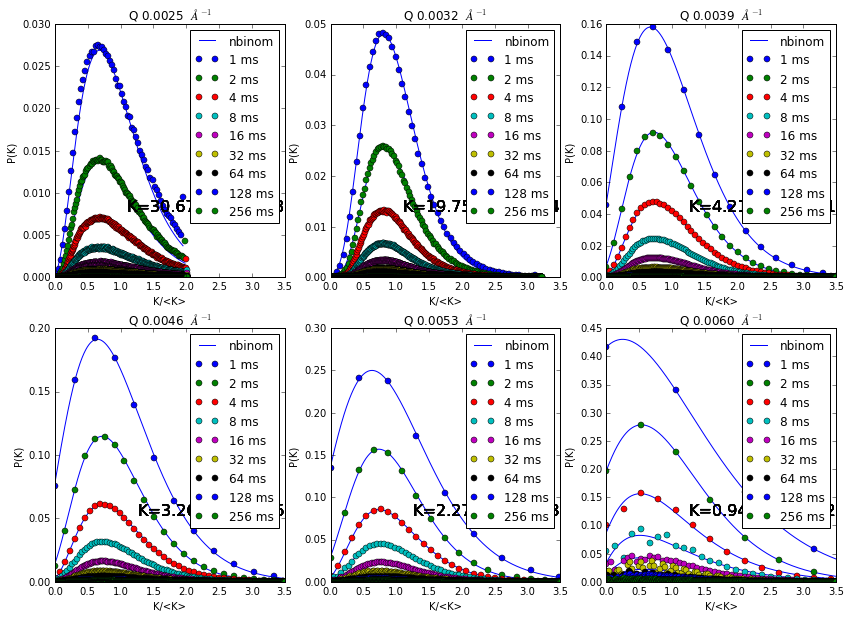

In [147]:
M_val = {}
K_val = {}
sx = int(round(np.sqrt(num_rings)))
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
fig = plt.figure(figsize=(14, 10))
plt.title('uid= %s'%uid+" Fitting with Negative Binomial Function", fontsize=20, y=1.02)  
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    M_val[i]=[]
    K_val[i]=[]
    for j in range(num_times):
        
        result_n = n_mod.fit(spe_cts_all[j, i],
                             bin_values=bin_edges[j, i][:-1],
                             K=5, M=12)
        M_val[i].append(result_n.best_values['M'])
        K_val[i].append(result_n.best_values['K'])
        axes = fig.add_subplot(sx, sy, i+1 )
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")
        
        fitx_ = np.linspace(0, max(Knorm_bin_edges[j, i][:-1]), 10000*2**j   )   
        
        fitx = np.linspace(0, max(bin_edges[j, i][:-1]), 10000*2**j   )         
        fity = nbinom_dist( fitx, K_val[i][j], M_val[i][j] )

        
        if j == 0:
            art, = axes.plot( fitx_,fity, '-b',  label="nbinom")
        else:
            art, = axes.plot( fitx_,fity, '-b')
            
        art, = axes.plot(Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], 'o',
                     label=str(time_steps[j])+" ms")
        
        axes.set_xlim(0, 3.5)
         
        axes.annotate(r'K='+'%.3f'%( K_val[i][0]) +','+r'M='+'%.3f'%(M_val[i][0]),
                      xy=(1, 0.25),
                      xycoords='axes fraction', fontsize=16,
                      horizontalalignment='right', verticalalignment='bottom')
        axes.set_title("Q "+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        axes.legend()
plt.show()
fig.tight_layout()  

In [149]:
K_mean

array([ 32.29428897,  20.23352745,   4.24605144,   3.30379269,
         2.29612359,   0.94858385])

In [133]:
#M_val#

In [150]:
contrast_factor = np.zeros((num_rings, num_times))
#k = 0
for i in range(num_rings):
    for j in range(num_times):
        contrast_factor[i, j] =  1/M_val[i][j]
        #k += 1
        
contrast_factor       

array([[ 0.26895912,  0.27082478,  0.27600106,  0.27852334,  0.27968582,
         0.27994702,  0.27985984,  0.2796423 ,  0.27943552],
       [ 0.15188833,  0.15082447,  0.15724325,  0.16046929,  0.16166488,
         0.16183363,  0.16154124,  0.16106895,  0.16055159],
       [ 0.19957426,  0.20675197,  0.24193568,  0.25926074,  0.26591672,
         0.26729784,  0.26628822,  0.26432812,  0.26209671],
       [ 0.18640457,  0.18846544,  0.23165488,  0.25272505,  0.26042527,
         0.26159425,  0.25984144,  0.25696511,  0.25381026],
       [ 0.13239362,  0.14127902,  0.20438336,  0.23486735,  0.24593644,
         0.24772325,  0.24531595,  0.24129982,  0.23686938],
       [ 0.16282298,  0.17666966,  0.3625637 ,  0.45479618,  0.47136119,
         0.45870938,  0.44202629,  0.42748239,  0.415012  ]])

## Get the contast factor of detected signals is 1/M

$ \beta = 1/M $

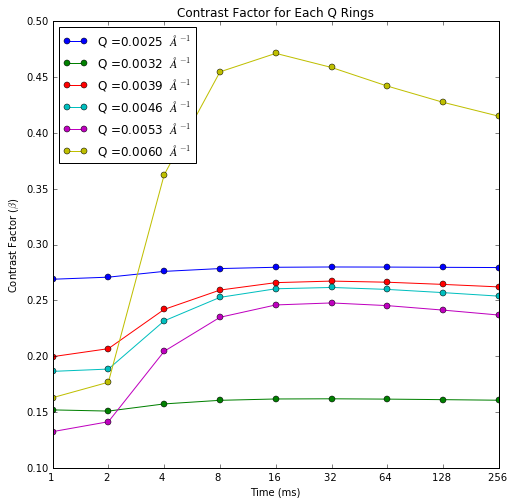

In [151]:
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(num_rings):
    ax.plot(contrast_factor[i, :], "-o", label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
    ax.set_ylabel("Contrast Factor " r'($\beta $)')
ax.set_title("Contrast Factor for Each Q Rings")
ax.set_xlabel("Time (ms)")
ax.legend(loc=2)
ax.set_xticks([j for j in range(num_times)])
ax.set_xticklabels(['%i ' % time_steps[j] for j in range(num_times)])
plt.show()

In [152]:
time_steps

[1, 2, 4, 8, 16, 32, 64, 128, 256]

In [161]:
contrast_factor[0, :]

array([ 0.26895912,  0.27082478,  0.27600106,  0.27852334,  0.27968582,
        0.27994702,  0.27985984,  0.2796423 ,  0.27943552])

In [153]:
relax_rate = []
dc_mod
for i in range(num_rings):
    result_dc = dc_mod.fit(contrast_factor[i, :], times=time_steps,
                           relaxation_rate=1.0, contrast_factor=0.78, cf_baseline=0)
    relax_rate.append(result_dc.best_values['relaxation_rate'])

In [154]:
relax_rate

[0.87085495827262172,
 0.61238333037218551,
 0.81594707413979373,
 0.74384508105390679,
 0.8118970173900909,
 1.02942729709083]

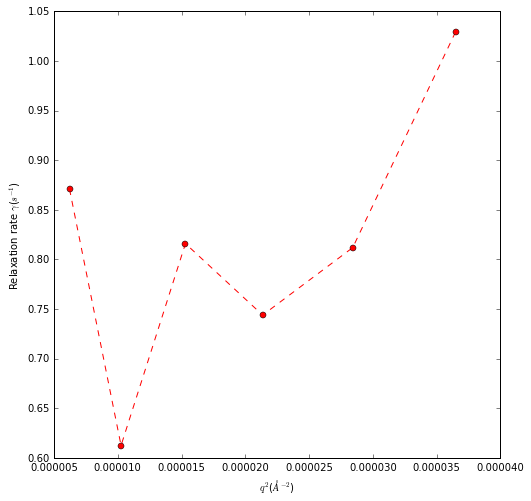

In [162]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(q_ring_center**2, relax_rate, 'ro', ls='--')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

In [156]:
D0 = np.polyfit(q_ring_center**2, relax_rate, 1)
gmfit = np.poly1d(D0)
'The fitted diffusion coefficient D0 is:  %.2E'r'($\AA^{-2}$)'%D0[0]

'The fitted diffusion coefficient D0 is:  7.08E+03($\\AA^{-2}$)'

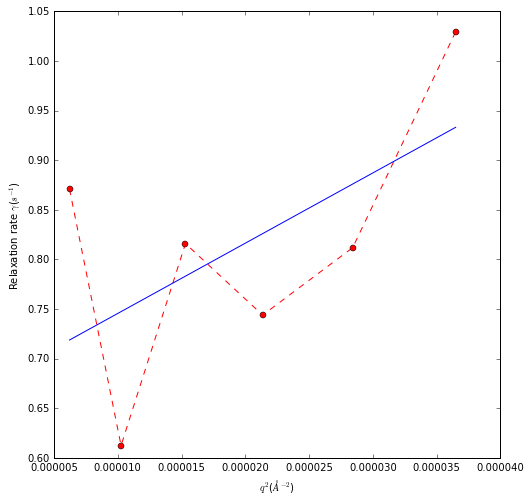

In [160]:
fig, ax = plt.subplots(figsize=(8, 8) )
ax.plot(q_ring_center**2, relax_rate, 'ro', ls='--')
ax.plot(q_ring_center**2,  gmfit(q_ring_center**2),  ls='-')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

### Fit with Gamma Distribution

In [167]:
K_mean

array([ 32.29428897,  20.23352745,   4.24605144,   3.30379269,
         2.29612359,   0.94858385])

In [187]:
def get_roi( data, threshold=1e-3):
    roi = np.where(data>threshold)
    #print roi[0].shape
    if len(roi[0]) > len(data)-2:
        roi = (np.array(roi[0][:-2]),)                    
    elif len(roi[0]) < 2:
        roi = np.where(data>=0)
    return roi[0]
        
    

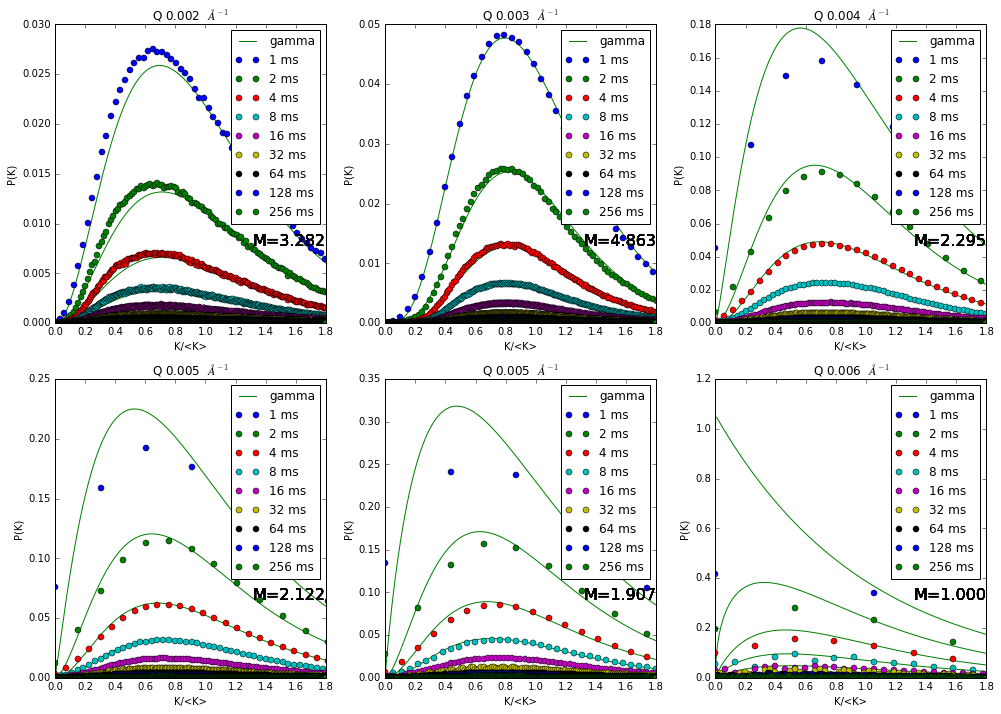

In [227]:

Mg_val = {}
fig = plt.figure(figsize=(14, 10))
plt.title('uid= %s'%uid+ " Fitting with Gamma Function", fontsize=20, y=1.02)  
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])

for i in range(num_rings):
    Mg_val[i] = []
    for j in range(num_times):        
        roi = get_roi( data = spe_cts_all[j, i], threshold=1e-6)  
        #print (roi)        
        result_g = g_mod.fit(spe_cts_all[j, i][roi],
                             bin_values=bin_edges[j, i][:-1][roi],
                             K=K_mean[i]*2**j, M=12)
        
        
        Mg_val[i].append(result_g.best_values['M'])
        axes = fig.add_subplot(sx, sy, i+1 )
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")
        
        
        fitx_ = np.linspace(0, max(Knorm_bin_edges[j, i][:-1]), 10000*2**j   )
        
        fitx = np.linspace(0, max(bin_edges[j, i][:-1]), 10000*2**j   )         
        fity = gamma_dist( fitx, K_mean[i]*2**j,  Mg_val[i][j] )

        
        if j == 0:
            art, = axes.plot( fitx_,fity, '-g',label="gamma") 
        else:
            art, = axes.plot( fitx_,fity, '-g' ) 
            
            
        art, = axes.plot( Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], 'o',
                     label=str(time_steps[j])+" ms")
                                  
        
        axes.set_xlim(0, 1.8)
        axes.annotate(r'M='+'%.3f'%(Mg_val[i][0]), xy=(1, 0.25),
                      xycoords='axes fraction', fontsize=16,
                      horizontalalignment='right', verticalalignment='bottom')
        axes.set_title("Q "+ '%.3f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        axes.legend()   
fig.tight_layout()         
plt.show()
 

## Fit with Poisson Distribution

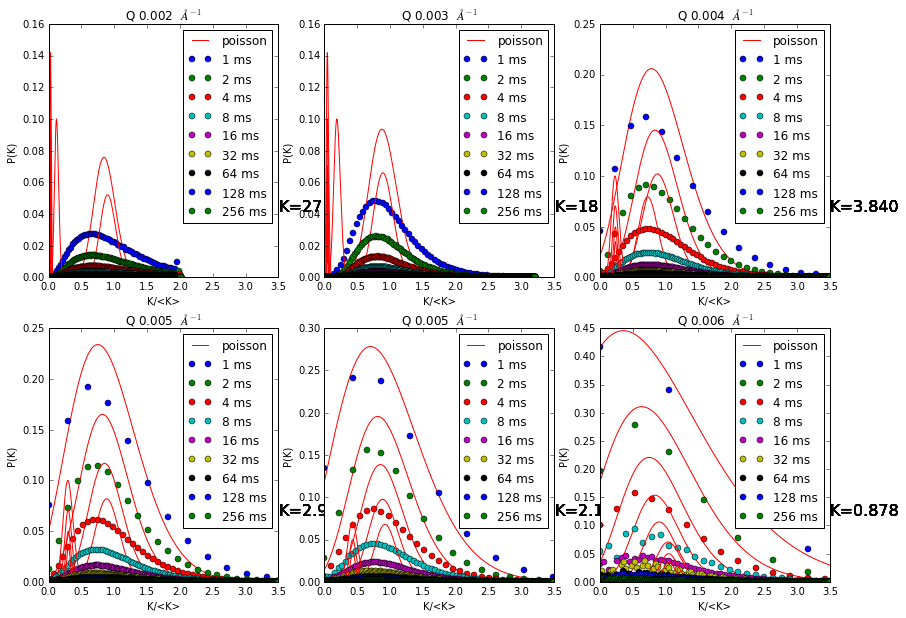

In [224]:
Kp_val = {}
sx = int(round(np.sqrt(num_rings)))
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
fig = plt.figure(figsize=(14, 10))
plt.title('uid= %s'%uid+" Fitting with Poission Function", fontsize=20, y=1.02)  
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])


for i in range(num_rings):
    Kp_val[i] = []
    for j in range(num_times):
        roi = get_roi( data = spe_cts_all[j, i], threshold=1e-6)   
        
        
        result_p = p_mod.fit(spe_cts_all[j, i][roi],
                             bin_values=bin_edges[j, i][:-1][roi],
                             K=1*2**j )  
        
        #if i==0:print (roi)             
        
        Kp_val[i].append(result_p.best_values['K'])
        axes = fig.add_subplot(sx, sy, i+1 )
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")
        
        
        
        fitx_ = np.linspace(0, max(Knorm_bin_edges[j, i][:-1]), 10000*2**j   )        
        fitx = np.linspace(0, max(bin_edges[j, i][:-1]), 10000*2**j   )         
        fity = poisson_dist( fitx, Kp_val[i][j]  ) 
        
        #fity = poisson_dist( fitx, K_mean[i]*2**j  ) 
       

        
        if j == 0:
            art, = axes.plot( fitx_,fity, '-r', label="poisson")
        else:
            art, = axes.plot( fitx_,fity, '-r' ) 
            
 
        art, = axes.plot( Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], 'o',
                     label=str(time_steps[j])+" ms")
        axes.set_xlim(0, 3.5)           
            
        axes.annotate(r'K='+'%.3f'%(Kp_val[i][0]), xy=(1, 0.25),
                      xycoords='axes fraction', fontsize=16,
                      horizontalalignment='best', verticalalignment='best')
        
        axes.set_title("Q "+ '%.3f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        axes.legend()
plt.show()
fig.tight_layout()  